## Introduction

This is a solution to the Project for the Logistic Regression Modeling in Python course on Dataquest!

I will be working on the Heart Disease Data Set from the UCI Machine Learning Repository. This dataset comes from the famous Cleveland Clinic Foundation, which recorded information on various patient characteristics, including age and chest pain, to try to classify the presence of heart disease in an individual. This a prime example of how machine learning can help solve problems that have a real impact on people's lives.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Load in the heart disease dataset
df = pd.read_csv("heart_disease.csv")

## Exploring The Dataset


In [3]:
# Columns in the dataset
df.columns

Index(['Unnamed: 0', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'present'],
      dtype='object')

The `present` column is binary outcome of interest. 0 encodes the absence of any heart disease, while 1 encodes the presence.

Note: the original dataset actually has a multiclass version of the problem, based on heart disease severity. I will be working on a reduced binary case for simplicity.

In [4]:
df.head()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,present
0,1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [5]:
df.dtypes

Unnamed: 0      int64
age             int64
sex             int64
cp              int64
trestbps        int64
chol            int64
fbs             int64
restecg         int64
thalach         int64
exang           int64
oldpeak       float64
slope           int64
ca             object
thal           object
present         int64
dtype: object

lets convert object type to int and float for `ca` and `thal`

In [6]:
print(df['ca'].value_counts())
print(df['thal'].value_counts())

0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64
3.0    166
7.0    117
6.0     18
?        2
Name: thal, dtype: int64


`ca` and `thal` has value ? in it. Since these are only 6 rows lets remove them

In [7]:
# get the index of rows with ? values
inds = df.query('(ca == "?") or (thal == "?")').index
np.array(inds)

array([ 87, 166, 192, 266, 287, 302])

In [8]:
# drop the rows with ? value
df = df.drop(inds)

In [12]:
# convert the objects to floats
df['ca'] = df['ca'].astype(float)
df['thal'] = df['thal'].astype(float)

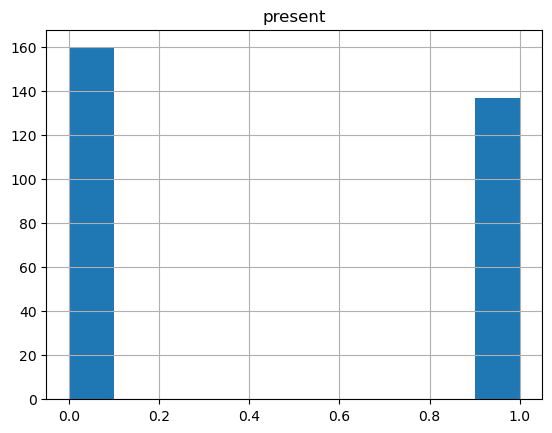

In [9]:
df.hist("present");

There's almost an equal number of cases and non-cases in the dataset.

In [20]:
df.groupby("present").mean().iloc[:,1:]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
present,,,,,,,,,,,,,
0,52.643750,0.556250,2.793750,129.175000,243.493750,0.143750,0.843750,158.581250,0.143750,0.598750,1.412500,0.275000,3.787500
1,56.759124,0.817518,3.583942,134.635036,251.854015,0.145985,1.175182,139.109489,0.540146,1.589051,1.824818,1.145985,5.832117


Some columns have a small, but noticeable difference when stratified by predictors. Based on the differences and some knowledge about heart disease, these seem like good candidates for predictors:

- age
- thalach (maximum heart rate achieved)
- restecg (resting ECG)
- ca (number of vessels colored by fluoroscopy)

## Dividing The Data

We'll use a 70-30 split of the dataset for the training and test sets.

In [22]:
X = df[["age", "thalach", "restecg", "ca"]]
y = df["present"]

# 70% for training set, 30% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [23]:
# Checking for separation in the datasets
print("Y_train: ", sum(y_train == 0))
print("Y_train: ", sum(y_train == 1))
print("Y_test: ", sum(y_test == 0))
print("Y_test: ", sum(y_test == 1))

Y_train:  109
Y_train:  98
Y_test:  51
Y_test:  39


We confirm above that there are both cases and non-cases in both the training and test sets



## Build The Model

In [24]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [25]:
# Checking the various metrics for the model
acc = model.score(X_train, y_train)

predictions = model.predict(X_train)
tp = sum((predictions == 1) & (y_train == 1))
fp = sum((predictions == 1) & (y_train == 0))
tn = sum((predictions == 0) & (y_train == 0))
fn = sum((predictions == 0) & (y_train == 1))
sens = tp / (tp + fn)
spec = tn / (tn + fp)

print("Training Accuracy: ", acc)
print("Training Sensitivity: ", sens)
print("Training Specificity: ", spec)

Training Accuracy:  0.7681159420289855
Training Sensitivity:  0.6632653061224489
Training Specificity:  0.8623853211009175


Overall the training accuracy was about 76%, the sensitivity was 66%, and the specificity was 86%. Based on these metrics, the model seems to perform better for non-cases.



## Interpreting The Model Coefficients


In [26]:
coefs = ["age", "thalach", "restecg", "ca"]

# Checking in terms of log-odds
for coef, val  in zip(coefs, model.coef_[0]):
    print(coef, ":", round(val, 2))

age : -0.02
thalach : -0.04
restecg : 0.39
ca : 1.18


In [27]:
# Checking in terms of odds
for coef, val  in zip(coefs, model.coef_[0]):
    print(coef, ":", round(np.exp(val), 2))

age : 0.98
thalach : 0.96
restecg : 1.47
ca : 3.25


Higher age and maximum heart rate (thalach) is associated with lower odds of heart disease holding the other predictors constant, but both of these odds ratios are close to 1.
Resting ECG and the number of colored vessels are associated with higher odds of heart disease holding the other predictors constant. These increases seem to be moderate and high, respectively (a 47% increase and 225% (!) increase).

## Final Model Evaluation


In [28]:
# Checking the various metrics for the model (test set)
acc = model.score(X_test, y_test)

predictions = model.predict(X_test)
tp = sum((predictions == 1) & (y_test == 1))
fp = sum((predictions == 1) & (y_test == 0))
tn = sum((predictions == 0) & (y_test == 0))
fn = sum((predictions == 0) & (y_test == 1))
sens = tp / (tp + fn)
spec = tn / (tn + fp)

print("Test Accuracy: ", acc)
print("Test Sensitivity: ", sens)
print("Test Specificity: ", spec)

Test Accuracy:  0.7555555555555555
Test Sensitivity:  0.7948717948717948
Test Specificity:  0.7254901960784313


## Drawing Conclusions

Test accuracy was 75%, sensitivity was 79%, and specificity was 72%. Compared to the training set, the accuracy didn't change much, while the model fared better with cases and worse with non-cases. This is potentially useful since this application is health-based. We might be more interested in being better at identifying cases than non-cases.